In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/home/lankenau/isotools/src')

In [3]:
import os
import logging
from isotools import Transcriptome
from isotools import __version__ as isotools_version
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# set up logging
logging.basicConfig(format="%(levelname)s:%(message)s", level=logging.INFO)
logger = logging.getLogger("isotools")
logger.info(f"This is isotools version {isotools_version}")

INFO:This is isotools version 0.3.5rc11


In [4]:

basepath = '/project/hfa_work/ENCODE/code/snakemake-pipeline/'
version = 2
tissue = 'brain'
path = os.path.join(basepath, f"results/isotools_v{version}/pkl/{tissue}.pkl")
isoseq = Transcriptome.load(path)

INFO:loading transcriptome from /project/hfa_work/ENCODE/code/snakemake-pipeline/results/isotools_v2/pkl/brain.pkl


In [5]:
classification = os.path.join(basepath, 'results/sqanti/isotools_v{version}/qc/{tissue}/brain_classification.txt')
isoseq.import_sqanti_classification(classification.format(version=version, tissue=tissue))

100%|██████████| 55811/55811 [00:22<00:00, 2499.33it/s]


In [6]:
isoseq.add_filter(tag='CAGE_SUPPORT', expression='sqanti_classification is not None and sqanti_classification["within_CAGE_peak"]', context='transcript', update=True)
isoseq.add_filter(tag='TSS_RATIO', expression='sqanti_classification is not None and sqanti_classification["ratio_TSS"] > 1.5', context='transcript', update=True)
isoseq.add_filter(tag='POLYA_SITE', expression='sqanti_classification is not None and sqanti_classification["within_polyA_site"]', context='transcript', update=True)
isoseq.add_filter(tag='POLYA_MOTIF', expression='sqanti_classification is not None and sqanti_classification["polyA_motif_found"]', context='transcript', update=True)

isoseq.add_filter(tag='SQANTI_SUPPORT', expression='CAGE_SUPPORT and TSS_RATIO and POLYA_SITE and POLYA_MOTIF', context='transcript', update=True)

In [7]:
next(isoseq.iter_transcripts(query='SQANTI_SUPPORT'))

(<isotools.gene.Gene object at 0x7f37eb4fa270>,
 0,
 {'exons': [[np.int64(108876985), 108877228],
   [108885506, 108885578],
   [108896863, 108897085],
   [108897491, 108897627],
   [108897958, 108898101],
   [108898641, 108898765],
   [108898878, 108898994],
   [108901789, 108901945],
   [108903125, 108903234],
   [108904124, 108904254],
   [108914337, 108914408],
   [108918612, 108918789],
   [108922416, 108922576],
   [108923999, 108924214],
   [108929700, np.int64(108930395)]],
  'strand': '+',
  'coverage': {'ENCSR700EBI': 10, 'ENCSR425HFS': 1, 'ENCSR463IDK': 10},
  'TSS': {'ENCSR700EBI': {108876981: 1,
    108876984: 1,
    108876985: 2,
    108876986: 1,
    108876988: 2,
    108876990: 1,
    108877106: 1,
    108877146: 1},
   'ENCSR425HFS': {108876984: 1},
   'ENCSR463IDK': {108876984: 5,
    108876985: 1,
    108876987: 2,
    108877098: 1,
    108877168: 1}},
  'PAS': {'ENCSR700EBI': {108930396: 7,
    108931627: 1,
    108930404: 1,
    108930391: 1},
   'ENCSR425HFS': {10

In [8]:
count = 0
for transcript in isoseq.iter_transcripts(query='SQANTI_SUPPORT'):
    count += 1
count

11661

In [9]:
coordination_results = isoseq.coordination_test(
    event_type=["TSS", "PAS"],
    min_total=10,
    min_alt_fraction=.01,
    transcript_filter="SQANTI_SUPPORT",
)
coordination_results_sig = coordination_results[coordination_results["padj"] < 0.05]
coordination_results_sig

,gene_id,gene_name,strand,eventA_type,eventB_type,eventA_start,eventA_end,eventB_start,eventB_end,pvalue,...,dcPSI_AB,dcPSI_BA,priA_priB,priA_altB,altA_priB,altA_altB,priA_priB_transcript_ids,priA_altB_transcript_ids,altA_priB_transcript_ids,altA_altB_transcript_ids
0,ENSG00000142875.21,PRKACB,+,TSS,PAS,84078084,84164341,84238491,84205294,6.468863e-05,...,-0.800000,-0.142857,2,5,28,0,[0],"[3, 2]",[1],[]
1,ENSG00000142875.21,PRKACB,+,TSS,PAS,84078084,84164694,84238491,84205294,2.317027e-13,...,-0.518519,-0.444444,2,24,28,0,[0],[4],[1],[]
3,ENSG00000117410.14,ATP6V0B,+,TSS,PAS,43974956,43974956,43978294,43978294,2.535606e-06,...,-0.815789,-0.157895,1,6,31,0,[6],[7],[3],[]
5,ENSG00000117682.18,DHDDS,+,TSS,PAS,26432378,26432379,26471294,26442230,5.134018e-07,...,0.833333,0.833333,30,0,0,6,[0],[],[],[1]
11,ENSG00000143569.20,UBAP2L,+,TSS,PAS,154220951,154220951,154263499,154270847,1.189676e-06,...,-0.771429,-0.200000,1,7,27,0,[0],[2],[1],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286,ENSG00000135047.16,CTSL,+,TSS,PAS,87726118,87726118,87731389,87731389,3.519092e-09,...,-0.113074,-0.431095,129,122,32,0,"[1, 7, 4]",[2],[8],[]
290,ENSG00000102103.18,PQBP1,+,TSS,PAS,48897928,48897928,48903139,48903139,2.459958e-13,...,-0.053892,-0.934132,2,156,9,0,"[0, 7]","[5, 1, 9, 2]",[6],[]
291,ENSG00000102103.18,PQBP1,+,TSS,PAS,48897928,48897928,48903139,48903139,5.686313e-12,...,-0.075630,-0.907563,2,108,9,0,"[0, 7]","[8, 3]",[6],[]
293,ENSG00000172465.14,TCEAL1,+,TSS,PAS,103628927,103629476,103630946,103630946,2.023412e-06,...,-0.620000,-0.220000,8,11,31,0,"[2, 0]",[3],[1],[]


In [10]:
coordination_results_unfiltered = isoseq.coordination_test(
    event_type=["TSS", "PAS"],
)
coordination_results_unfiltered_sig = coordination_results_unfiltered[coordination_results_unfiltered["padj"] < 0.05]
coordination_results_unfiltered_sig

,gene_id,gene_name,strand,eventA_type,eventB_type,eventA_start,eventA_end,eventB_start,eventB_end,pvalue,...,dcPSI_AB,dcPSI_BA,priA_priB,priA_altB,altA_priB,altA_altB,priA_priB_transcript_ids,priA_altB_transcript_ids,altA_priB_transcript_ids,altA_altB_transcript_ids
0,ENSG00000116685.17,KIAA2013,-,TSS,PAS,11923115,11926406,11920067,11922635,3.844766e-03,...,0.022754,0.131274,34,186,0,39,[3],"[2, 4, 9, 25, 28, 29]",[],"[11, 36]"
8,ENSG00000116754.14,SRSF11,+,TSS,PAS,70205720,70221477,70251998,70228941,3.982479e-03,...,0.123251,0.155808,44,31,17,36,"[0, 7, 6, 41, 42, 47, 48]","[14, 66, 15, 51, 52, 21, 22, 23, 53, 55, 58, 2...","[2, 9]",[10]
9,ENSG00000116754.14,SRSF11,+,TSS,PAS,70205720,70221477,70251998,70228941,1.127440e-04,...,0.172215,0.214457,59,30,17,36,"[1, 3, 4, 65, 5, 38, 45]","[16, 25, 24, 18, 20, 59]","[2, 9]",[10]
15,ENSG00000132692.19,BCAN,+,TSS,PAS,156642115,156652592,156653466,156659524,8.384873e-03,...,0.200000,0.037097,31,0,101,23,"[0, 4, 15, 68]",[],"[3, 25, 20, 62, 63]","[47, 48, 66]"
16,ENSG00000084072.17,PPIE,+,TSS,PAS,39738884,39738884,39753698,39763909,2.452557e-03,...,-0.212766,-0.039683,142,29,234,18,"[8, 35, 55, 36, 38, 73, 42, 44, 53, 61]","[13, 56, 64, 72, 54]","[5, 6, 11, 18, 24, 9, 41, 43, 45, 46, 74, 19, ...","[14, 58, 37, 15, 16]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
470,ENSG00000165698.16,SPACA9,+,TSS,PAS,132878335,132887386,132890030,132890029,7.270459e-14,...,-0.190447,-0.507858,45,102,37,2,"[0, 2, 4]","[11, 18]","[3, 14]",[12]
473,ENSG00000183837.10,PNMA3,+,TSS,PAS,153056474,153058740,153060461,153060461,6.544553e-12,...,0.472727,0.120627,130,0,108,37,[4],[],"[5, 8, 18, 19]",[10]
474,ENSG00000046653.15,GPM6B,-,TSS,PAS,13938622,13817079,13770942,13774042,5.498255e-173,...,-0.257207,-0.064657,189,445,3971,739,"[0, 18, 11, 15]","[1, 2, 62, 7, 10, 19, 65, 67, 12, 76, 81, 21]","[6, 30, 50, 37, 20, 28, 51, 33, 54, 59, 29, 39...","[17, 27, 47, 57, 91]"
475,ENSG00000046653.15,GPM6B,-,TSS,PAS,13817079,13779836,13770942,13774042,9.413452e-18,...,0.297251,0.045361,445,6,739,126,"[1, 2, 62, 7, 10, 19, 65, 67, 12, 76, 81, 21]",[8],"[17, 27, 47, 57, 91]",[32]


([<matplotlib.axis.YTick at 0x7f37f4a3c410>,
 [Text(0, 0.5, 'pri'), Text(0, 1.5, 'alt')])

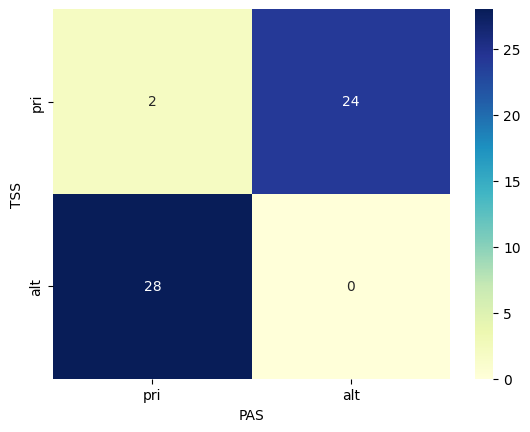

In [11]:
# Display a contingency table for a specific event
first_event = coordination_results_sig.iloc[1]
# priA_priB	priA_altB	altA_priB	altA_altB
con_tab = [[first_event["priA_priB"], first_event["priA_altB"]], [first_event["altA_priB"], first_event["altA_altB"]]]
sns.heatmap(con_tab, annot=True, fmt="d", cmap="YlGnBu")
# Axis labels
plt.ylabel("TSS")
plt.xlabel("PAS")
# ticks
plt.xticks([0.5, 1.5], ["pri", "alt"])
plt.yticks([0.5, 1.5], ["pri", "alt"])

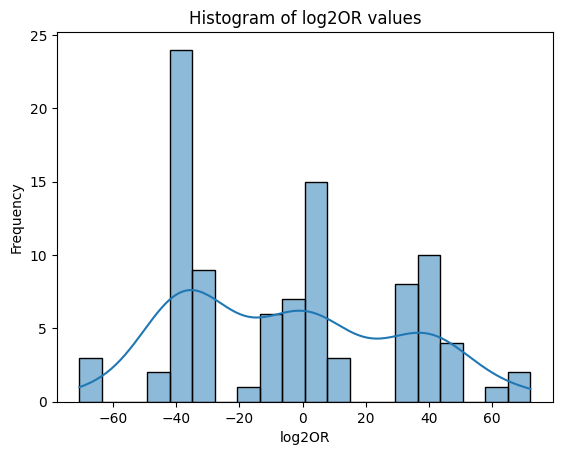

In [12]:
# Histogram of log2OR values
sns.histplot(coordination_results_sig["log2OR"], bins=20, kde=True)
plt.xlabel("log2OR")
plt.ylabel("Frequency")
plt.title("Histogram of log2OR values")
plt.show()

In [13]:
# Taken from Carmine with minor adjustments
# https://github.com/carmineceraolo/splicing-coordination/blob/main/sheet05.ipynb
def volcano_plot(df,ax = None,sig=0.05,sigor=1.5,tag="(add a tag)",normalized=False):

    if ax is None:
        fig,ax = plt.subplots(figsize=(10,5))

    palette=sns.color_palette().as_hex()
    colors=[]

    for i,r in df.iterrows():
        if r.padj>=sig or abs(r.log2OR)<=sigor:
            colors.append(palette[7])
        else:
            colors.append(palette[0])


    x=np.array(df.log2OR)

    if normalized == True:
        sigor-=np.mean(x)
        sigor/=np.std(x)
        x-=np.mean(x)
        x/=np.std(x)

        y=np.array(df.padj)

        sig-=np.mean(y)
        sig/=np.std(y)

        y-=np.mean(y)
        y/=np.std(y)
        y=-np.log10(y)
        title=f"Normalized volcano plot of {tag}"
    else:
        y=np.array(-np.log10(df.padj))
        title=f"Volcano plot of {tag}"

    ax.scatter(x,y,c=colors)
    ax.axhline(y=-np.log10(sig),color="red",linestyle='dotted',label=f"padj = {sig}")
    ax.axvline(x=sigor,color="green",linestyle='dotted',label=f"log2OR threshold = {sigor}")
    ax.axvline(x=-sigor,color="green",linestyle='dotted')




    ax.set_title(title,fontsize=13+7)
    ax.set_ylabel("-log10(p_value)",fontsize=12)
    ax.set_xlabel("log2OR",fontsize=12)
    ax.legend(frameon=True,fontsize=12)

/home/lankenau/miniforge-pypy3/envs/isodev/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


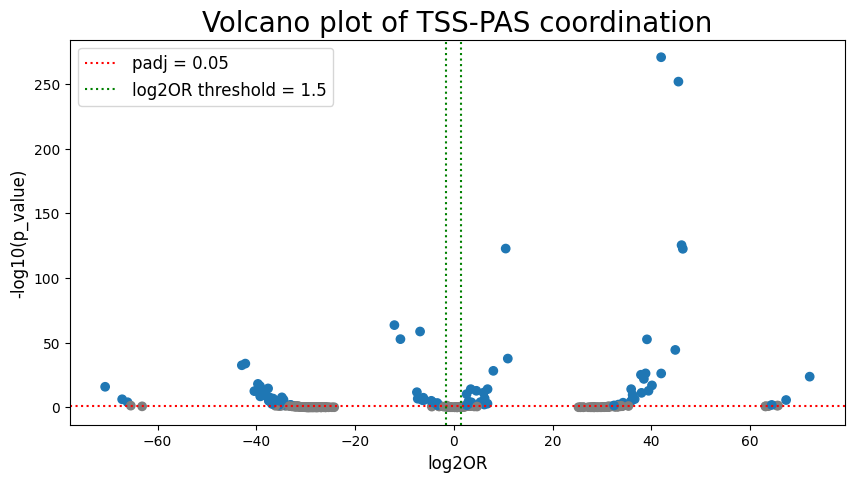

In [14]:
volcano_plot(coordination_results, tag="TSS-PAS coordination")